# We have collected 120G of data, here we analyze what the label distribution looks like 

In [3]:
import base64
VERBOSE = True 

def get_base64_str_from_jpg(file_path):
    # Step 1: Open the .jpg file in binary mode
    with open(file_path, 'rb') as image_file:
        # Step 2: Read the file's binary content
        image_binary = image_file.read()
    
    # Step 3: Encode the binary data into a Base64 string
    base64_str = base64.b64encode(image_binary).decode('utf-8')
    
    return base64_str

def log(msg:str, verbose:bool=False):
    if VERBOSE:
        print(msg)

In [67]:
def parse_litter_label(label: str): 
    label_type = ''
    litter_size = '' 
    litter_category = '' 
    label_cleaned = label.lower().strip()
    if label_cleaned.startswith('litter-'):
        label_type = 'litter'
        litter_size = label_cleaned.split('-')[1]
        litter_category = label_cleaned.split(f'{litter_size}-')[1].replace('o t h e r - ', 'other-')
    elif label_cleaned.startswith('grabber'):
        label_type = 'grabber' 
    else:
        raise Exception('Not the correct format of {Litter}-{small}-{Lids - Plastic}')
    return (label_type, litter_size,litter_category)

In [68]:
# First prepare the labels to normalize them  
import cv2
import os 
import json 
import pandas as pd

def get_litter_labels(img_dir: str, img_file: str):
    log(msg=f"{img_height=} by {img_width=}")
    if 'resized' in img_file:
        return 
    json_file = img_file.split('.')[0] + '.json' 

    litter_label_dataframe = []
    litter_label_dataframe.append(['class', 'size', 'category'])
    
    with open(f'{img_dir}/{json_file}', 'r') as json_file_content:
        json_data = json.load(json_file_content)
        shapes = json_data['shapes']
        for s in shapes:
            if s['label'] != 'Grabber' and s['shape_type'] == 'rectangle':
                x1_litter,y1_litter = s['points'][0] 
                x2_litter,y2_litter = s['points'][1]
                
                try:
                    label_type, litter_size,litter_category = parse_litter_label(s['label'])
                    litter_label_dataframe.append([label_type, litter_size,litter_category])
                except:
                    print(f'Parsing failed! {img_dir=} {img_file=}')
                
                 
    return pd.DataFrame(litter_label_dataframe[1:], columns=litter_label_dataframe[0])

In [69]:
parse_litter_label('grabber')

('grabber', '', '')

In [70]:
parse_litter_label('Litter-small-Lids - Plastic')

('litter', 'small', 'lids - plastic')

In [71]:
import pandas as pd
VERBOSE = True

img_dir = 'litter_survey_dataset/Annotation Batch 2 Kirkland 20250105'
img_file = 'IMG_20250105_151439_612.jpeg'
img_content = cv2.imread(f'{img_dir}/{img_file}')
img_height, img_width = img_content.shape[:2]
log(img_height, img_width)

get_litter_labels(img_dir=img_dir,img_file=img_file)


1440
img_height=1440 by img_width=2560


,class,size,category
0,litter,small,lids - plastic


In [72]:
data_batch_folders = [
    '/app/litter_survey_dataset/SampleImageToAnnotate',
    '/app/litter_survey_dataset/Annotation Batch 1 Kirkland 20231216',
    '/app/litter_survey_dataset/Annotation Batch 2 Kirkland 20250105',
    '/app/litter_survey_dataset/Annotation Batch 3 Bellevue Woodinville 20240721',
    '/app/litter_survey_dataset/Annotation Batch 4 Kirkland 20240310'
]

In [113]:
import os 
import cv2 
VERBOSE = False  

img_ct = 0 
img_app_dir_ct = 0

litter_label_df = pd.DataFrame(columns=['class', 'size', 'category'])
litter_label_app_dir_df = pd.DataFrame(columns=['class', 'size', 'category'])

for data_batch_folder in data_batch_folders:
    
    img_dirs = [data_batch_folder, data_batch_folder.replace('/app/','')]
    for img_dir in img_dirs:
        print(f'Processing {img_dir}, already processed {img_ct=} {img_app_dir_ct=}')
        all_labeled_images = os.listdir(img_dir)

        
        for img_file in all_labeled_images:
            if img_file.endswith('.jpeg') and '_resized.' not in img_file:
                log(img_file)
                label_df = get_litter_labels(img_dir=img_dir,img_file=img_file)
                log(label_df)
                
                if img_dir.startswith('/app/'):
                    img_app_dir_ct+=1
                    litter_label_app_dir_df =  pd.concat([litter_label_app_dir_df, label_df])
                else:
                    img_ct += 1 
                    litter_label_df =  pd.concat([litter_label_df, label_df])
                
                log(f'{img_ct=} {img_app_dir_ct=}')
                
print('Done')

Processing /app/litter_survey_dataset/SampleImageToAnnotate, already processed img_ct=0 img_app_dir_ct=0
Processing litter_survey_dataset/SampleImageToAnnotate, already processed img_ct=0 img_app_dir_ct=37
Processing /app/litter_survey_dataset/Annotation Batch 1 Kirkland 20231216, already processed img_ct=37 img_app_dir_ct=37
Processing litter_survey_dataset/Annotation Batch 1 Kirkland 20231216, already processed img_ct=37 img_app_dir_ct=270
Processing /app/litter_survey_dataset/Annotation Batch 2 Kirkland 20250105, already processed img_ct=270 img_app_dir_ct=270
Processing litter_survey_dataset/Annotation Batch 2 Kirkland 20250105, already processed img_ct=270 img_app_dir_ct=503
Processing /app/litter_survey_dataset/Annotation Batch 3 Bellevue Woodinville 20240721, already processed img_ct=503 img_app_dir_ct=503
Processing litter_survey_dataset/Annotation Batch 3 Bellevue Woodinville 20240721, already processed img_ct=503 img_app_dir_ct=715
Processing /app/litter_survey_dataset/Annota

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

def display_category_count(category_counts):
    plt.figure(figsize=(8, 6))
    category_counts.plot(kind='barh', xlabel='Count', ylabel='Litter Category', title='Litter Category Counts', legend=False)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    for category, count in category_counts.items():
        # Display the counts
        log(f"class '{category}' count {count}")
        
    for index, value in enumerate(category_counts):
        plt.text(value + 0.1, index, str(value), va='center')

    plt.tight_layout()
    
    # Display the plot
    plt.show()

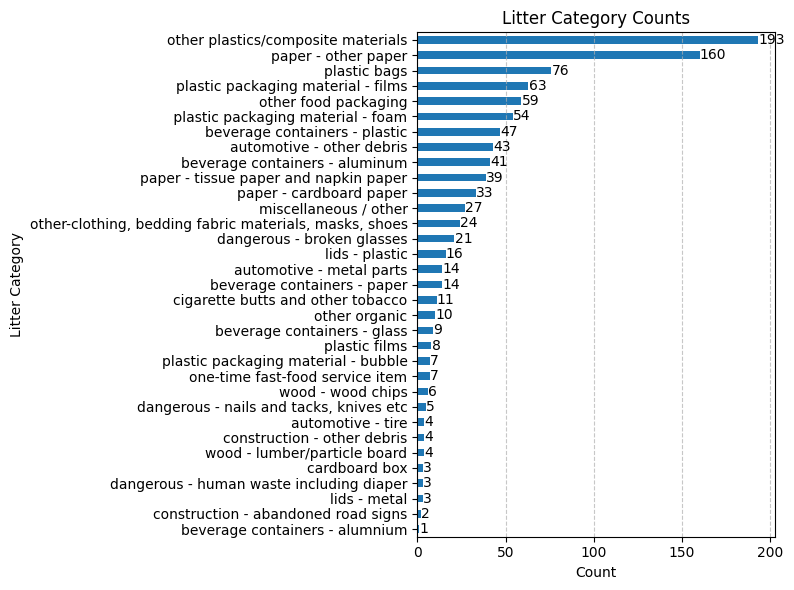

In [115]:
category_counts = litter_label_df['category'].value_counts().sort_values(ascending=True)
display_category_count(category_counts)

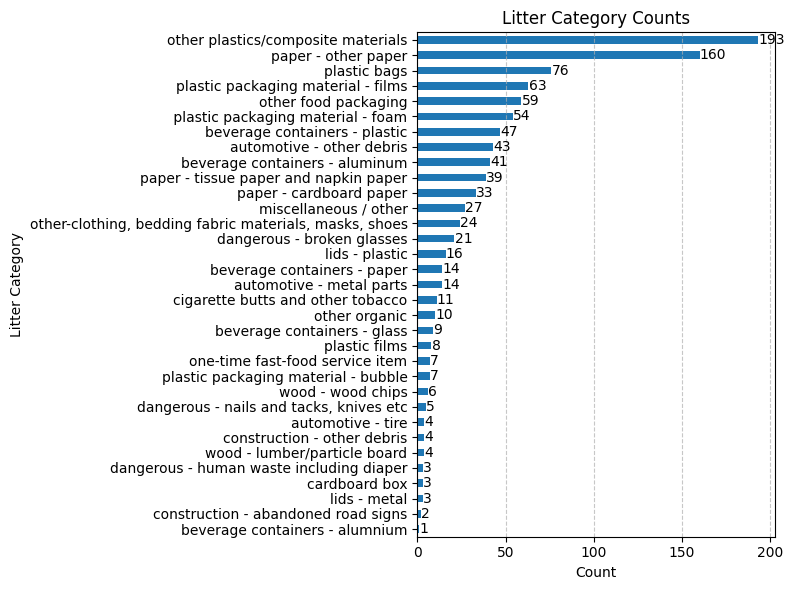

In [116]:
category_app_dir_counts = litter_label_app_dir_df['category'].value_counts().sort_values(ascending=True)
display_category_count(category_app_dir_counts)

In [117]:

# Combine both Series into a DataFrame for comparison
comparison_df = pd.DataFrame({'count_1': category_counts, 'count_2': category_app_dir_counts}).fillna(0)

# Identify rows where counts differ
differences = comparison_df[comparison_df['count_1'] != comparison_df['count_2']]

# Print the differing classes
for class_name, row in differences.iterrows():
    print(f"Class '{class_name}': count_1 = {row['count_1']}, count_2 = {row['count_2']}")
print('Done')

Done
